In [10]:
import pandas as pd
import re
import numpy as np
from sklearn import metrics
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.cross_validation import cross_val_score
#from nltk import FreqDist
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chrys\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
en_stop = stopwords.words("english")

In [3]:
list=["biology","cooking","crypto","diy","robotics","travel"]

Read each csv file individually and return dataframes cleaned up (no NA values, no symbols such as new paragraph or new line) 

In [14]:
def get_df(x):
    path = 'stackexchange/{}.csv'.format(str(x))
    dataframe = pd.read_csv(path,usecols=['title','content','tags'],index_col=0)
    dataframe = dataframe.reset_index()
    dataframe.dropna()
    dataframe = dataframe.replace(re.compile('<.*?>'), ' ')
    dataframe = dataframe.replace(re.compile('\n'), ' ')
    return dataframe

biology = get_df('biology')
cooking = get_df('cooking')
crypto = get_df('crypto')
diy = get_df('diy')
robotics = get_df('robotics')
travel = get_df('travel')
test = get_df('test')

Make a new dataframe called training_set consisting of the training set data. (all datasets concatenated)

In [5]:
training_list=[]
for x in list:
    path = 'stackexchange/{}.csv'.format(str(x))
    training_list.append(pd.read_csv(path,usecols=['title','content','tags'],index_col=0))
complete_set = pd.concat(training_list, axis=0 , join='outer')
complete_set.dropna()
complete_set= complete_set.reset_index()
complete_set.head(10)
complete_set = complete_set.replace(re.compile('<.*?>'), ' ')
complete_set = complete_set.replace(re.compile('\n'), ' ')

In [6]:
complete_set.shape

(87000, 3)

In [7]:
print(complete_set['tags'].values)

['ribosome binding-sites translation synthetic-biology' 'rna biochemistry'
 'immunology cell-biology hematology' ...,
 'customs-and-immigration officials registration macedonia' 'visas austria'
 'untagged']


Combine all columns of complete_set to a 3-tuple 

In [8]:
subset = complete_set[['title','content','tags']]
tuples = [tuple(x) for x in subset.values]
print(len(tuples))

87000


Get some tags 

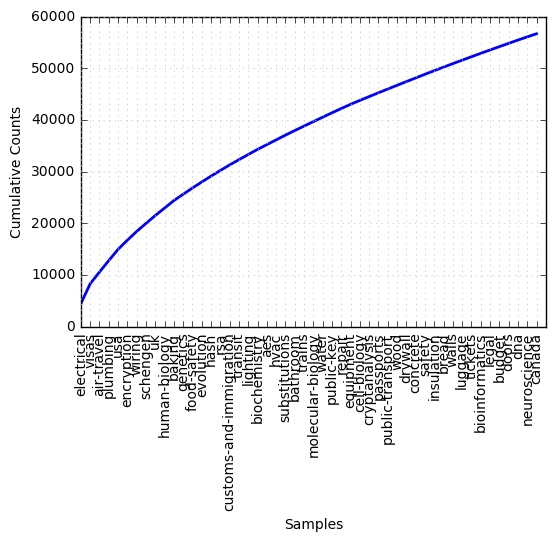

In [12]:
tags=[]
for tag in complete_set['tags']:
    for t in tag.split():
        tags.append(t)
fdist1 = FreqDist(tags)
#fdist1.most_common(50)
fdist1.plot(50, cumulative=True)

In [16]:
test.shape

(81926, 3)

In [17]:
test.head(20)

,id,title,content
0,What is spin as it relates to subatomic partic...,I often hear about subatomic particles having...,NaN
1,What is your simplest explanation of the strin...,How would you explain string theory to non ph...,NaN
2,"Lie theory, Representations and particle physics",This is a question that has been posted at ma...,NaN
3,Will Determinism be ever possible?,What are the main problems that we need to so...,NaN
4,Hamilton's Principle,Hamilton's principle states that a dynamic sy...,NaN
5,What is sound and how is it produced?,"I've been using the term ""sound"" all my life,...",NaN
6,What experiment would disprove string theory?,I know that there's big controversy between t...,NaN
7,Why does the sky change color? Why the sky is ...,Why does the sky change color? Why the sky is...,NaN
8,How's the energy of particle collisions calcul...,Physicists often refer to the energy of colli...,NaN
9,Monte Carlo use,Where is the Monte Carlo method used in physi...,NaN


In [30]:
print(' Cooking: ')
print(cooking.shape)
print(' Biology: ')
print(biology.shape)
print(' DIY: ')
print(diy.shape)
print(' Robotics: ')
print(robotics.shape)
print(' Travel: ')
print(travel.shape)
print(' Crypto: ')
print(crypto.shape)


 Cooking: 
(15404, 3)
 Biology: 
(13196, 3)
 DIY: 
(25918, 3)
 Robotics: 
(2771, 3)
 Travel: 
(19279, 3)
 Crypto: 
(10432, 3)


In [35]:
cooking.head(10)

,title,content,tags
0,How can I get chewy chocolate chip cookies?,My chocolate chips cookies are always too cri...,baking cookies texture
1,How should I cook bacon in an oven?,I've heard of people cooking bacon in an oven...,oven cooking-time bacon
2,What is the difference between white and brown...,"I always use brown extra large eggs, but I ca...",eggs
3,What is the difference between baking soda and...,And can I use one in place of the other in ce...,substitutions please-remove-this-tag baking-so...
4,"In a tomato sauce recipe, how can I cut the ac...",It seems that every time I make a tomato sauc...,sauce pasta tomatoes italian-cuisine
5,What ingredients (available in specific region...,I have a recipe that calls for fresh parsley....,substitutions herbs parsley
6,What is the internal temperature a steak shoul...,I'd like to know when to take my steaks off t...,food-safety beef cooking-time
7,How should I poach an egg?,What's the best method to poach an egg withou...,eggs basics poaching
8,"How can I make my Ice Cream ""creamier""",My ice cream doesn't feel creamy enough. I g...,ice-cream
9,How long and at what temperature do the variou...,"I'm interested in baking thighs, legs, breast...",baking chicken cooking-time


Get the titles from the complete set

In [36]:
titles_only=complete_set['title']
titles_only.shape

(87000,)

In [37]:
titles_only.head(10)

0    What is the criticality of the ribosome bindin...
1    How is RNAse contamination in RNA based experi...
2        Are lymphocyte sizes clustered in two groups?
3    How long does antibiotic-dosed LB maintain goo...
4          Is exon order always preserved in splicing?
5         How can I avoid digesting protein-bound DNA?
6      Under what conditions do dendritic spines form?
7                          How should I ship plasmids?
8    What is the reason behind choosing the reporte...
9              How many times did endosymbiosis occur?
Name: title, dtype: object

AttributeError: 'Series' object has no attribute 'split'

In [40]:
print(titles_only.str.split().head(10))

0    [What, is, the, criticality, of, the, ribosome...
1    [How, is, RNAse, contamination, in, RNA, based...
2    [Are, lymphocyte, sizes, clustered, in, two, g...
3    [How, long, does, antibiotic-dosed, LB, mainta...
4    [Is, exon, order, always, preserved, in, splic...
5    [How, can, I, avoid, digesting, protein-bound,...
6    [Under, what, conditions, do, dendritic, spine...
7                    [How, should, I, ship, plasmids?]
8    [What, is, the, reason, behind, choosing, the,...
9       [How, many, times, did, endosymbiosis, occur?]
Name: title, dtype: object
